<a href="https://colab.research.google.com/github/bogatovam/arima-example/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подготовка данных

In [ ]:
!pip install ml_metrics -q

In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
url = "https://raw.githubusercontent.com/bogatovam/arima-example/main/ts_data.csv"
dataset = pd.read_csv(url, index_col=['time'], parse_dates=['time'])

In [ ]:
dataset

,data
time,
2012-02-28 00:00:00,24481.128283
2012-02-28 01:00:00,24479.922945
2012-02-28 02:00:00,26176.343423
2012-02-28 03:00:00,28428.398411
2012-02-28 04:00:00,31926.022702
...,...
2012-03-07 02:00:00,32094.642618
2012-03-07 03:00:00,34723.265070
2012-03-07 04:00:00,39496.303172


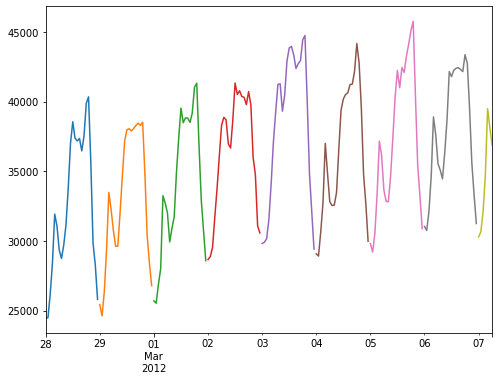

In [ ]:
dataset_by_day = dataset.resample('D')
dataset_by_day.plot(figsize=(8, 6))
pass

Видно, что ряд является сезонным - графики по дням очень похожи между собой. 

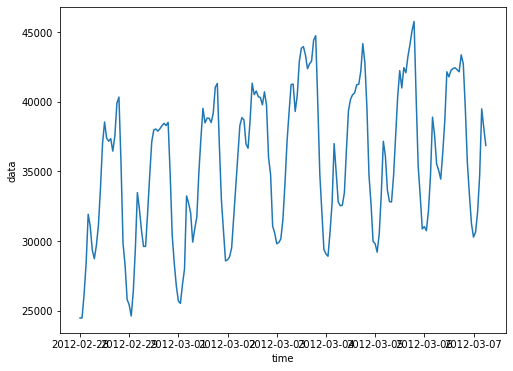

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=dataset, x="time", y="data")
pass

По графику видно, что он имеет слабо выраженный тренд, следовательно временной ряд не является стационарным. 

In [ ]:
dataset_stat = dataset.describe()
dataset_stat

,data
count,199.000000
mean,35646.252502
std,5165.264588
min,24479.922945
25%,31115.195320
50%,36111.180115
75%,39835.280887
max,45770.070309


Так как ряд нестационарный, получим из него ряд первых разностей.

In [ ]:
dataset_diff1 = dataset.diff(periods=1).dropna()

Проверим ряд на стационарность критерием Dickey-Fuller-а.

In [ ]:
test = sm.tsa.adfuller(dataset_diff1['data'])
print( 'p-value: ', test[1])
if test[0]> test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

p-value:  1.7101741145847592e-08
Единичных корней нет, ряд стационарен


Как видно из кода выше получившийся ряд первых разностей практически является стационарным - p-value достаточно мало.

Для того, чтобы убедиться, что ряд первых разностей стационарен, проверим его на отсутствие тренда.

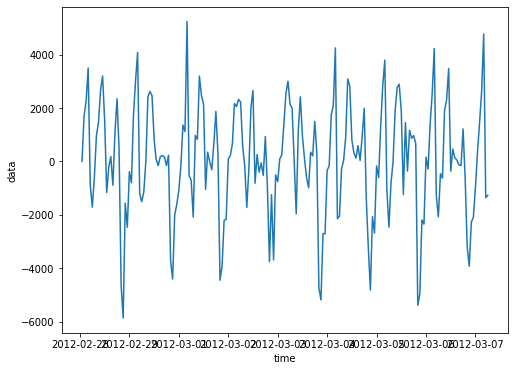

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=dataset_diff1, x="time", y="data")
pass

Построим сглаженный ряд, на котором можно с большей уверенностью судить о тренде.

In [ ]:
sm_dataset= dataset_diff1.rolling(24).mean().dropna()

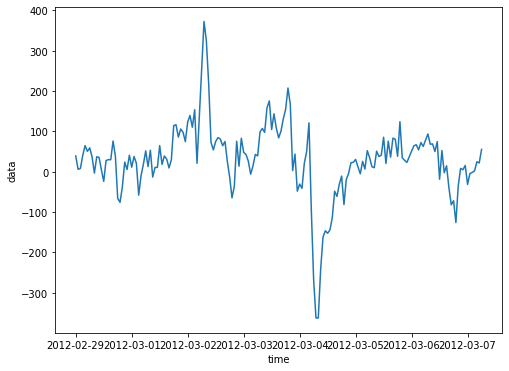

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=sm_dataset, x="time", y="data")
pass

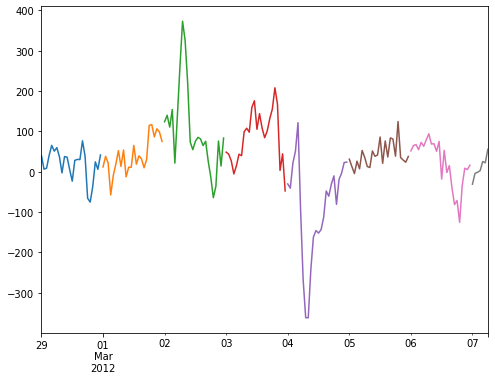

In [ ]:
sm_dataset = sm_dataset.resample('D')
sm_dataset.plot(figsize=(8, 6))
pass

Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.

## ARIMA
Парамтеры модели:

*   **d = 1** - порядок интегрированного ряда
*   **p** - порядок компоненты авторегрессии
*   **q** - порядок компоненты скользящего среднего


Необходимо определить p и q. Для их определения надо изучить авторкорреляционную (ACF) и частично автокорреляционную (PACF) функции для ряда первых разностей.

В обеих функциях ищем сильно отличные от нуля коэф-ты.

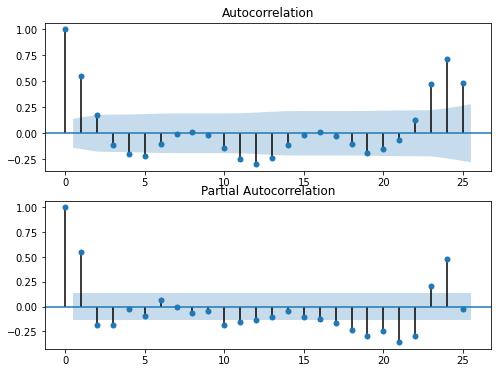

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset_diff1.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset_diff1, lags=25, ax=ax2)

После изучения коррелограммы PACF можно сделать вывод, что **p = 1**, т.к. на ней только 1 лаг сильно отличнен от нуля (24 не рассматриваем, так как очевидна сезонность по дням). По коррелограмме ACF можно увидеть, что **q = 1**. 

Но все равно проведем эксперименты и найдем лучшие параметры модели. 

In [ ]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [ ]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [ ]:
train_dataset = dataset[30:]
test_dataset = dataset[:30]

In [ ]:
%%time
results = []
best_aic = float("inf")

warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_dataset['data'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, 
                                                        param[3], 24)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

CPU times: user 50.2 s, sys: 35.8 s, total: 1min 26s
Wall time: 43.6 s


In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
1   (0, 0, 0, 1)  2455.316305
3   (0, 0, 1, 1)  2456.116700
9   (1, 0, 0, 1)  2457.169644
11  (1, 0, 1, 1)  2457.971673
13  (1, 1, 0, 1)  2459.065201


In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               data   No. Observations:                  169
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 24)   Log Likelihood               -1225.658
Date:                            Sat, 20 Mar 2021   AIC                           2455.316
Time:                                    18:16:43   BIC                           2461.256
Sample:                                02-29-2012   HQIC                          2457.730
                                     - 03-07-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L24      -0.3335      0.048     -6.916      0.000      -0.428      -0.239
sigma2      1.393e+06   1.17e+05   

## Оценка модели

In [ ]:
from scipy import stats

print("Student's criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Student's criterion: p=0.225263
Dickey-Fuller criterion: p=0.000000


Text(0, 0.5, 'Residuals')

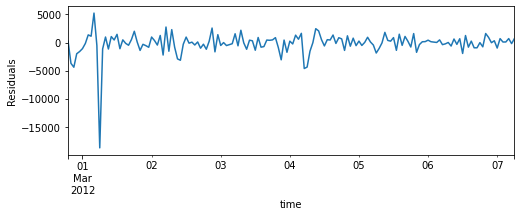

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

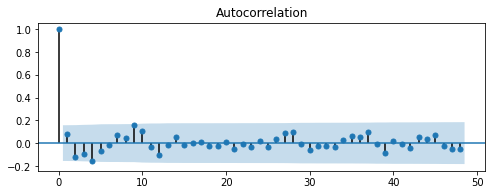

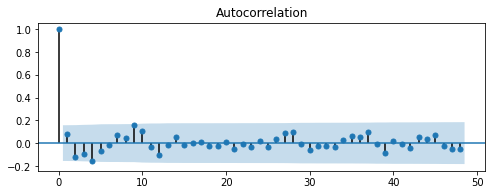

In [ ]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

Остатки стационарны, не смещенны, явных автокореляций нет. Посчитаем некоторые метрики модели:

In [ ]:
predict = best_model.predict(-30, -1, typ='levels')

Среднеквадратичное отклонение модели:

In [ ]:
import ml_metrics as metrics

metrics.rmse(test_dataset, predict)

8580.091831940541

Средняя абсолютная ошибка:

In [ ]:
metrics.mae(test_dataset, predict)

7085.713965330724

## Предсказание

In [ ]:
dataset_with_predict = dataset.copy()

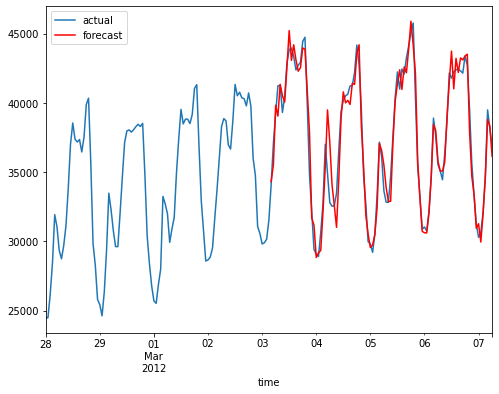

In [ ]:
plt.figure(figsize=(8, 6))
dataset_with_predict['model'] = best_model.fittedvalues
dataset_with_predict['data'].plot(label='actual')
dataset_with_predict['model'][100:].plot(color='r', label='forecast')
plt.legend();

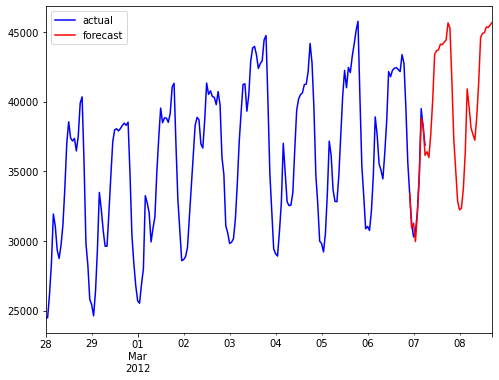

In [ ]:
from dateutil.relativedelta import relativedelta

plt.figure(figsize=(8, 6))
dataset_with_predict = dataset[['data']]
date_list = [pd.datetime.strptime("2012-03-07 06:00:00", "%Y-%m-%d %H:%M:%S") + relativedelta(hours=x) for x in range(1,36)]
future = pd.DataFrame(index=date_list, columns=dataset_with_predict.columns)
dataset_with_predict = pd.concat([dataset_with_predict, future])
dataset_with_predict['forecast'] = best_model.predict(start=160, end=250)

dataset_with_predict['data'].plot(color='b', label='actual')
dataset_with_predict['forecast'].plot(color='r', label='forecast')
plt.legend();

## Вывод

Модель неплохо предсказывает последующие значения ряда, причем как на тренировке, так и на тесте. 